## This file consists of functions for CRLM dataset as follow:
1. Transform JSON to Mask
2. tiff to png
3. crop from 1000x1000 to 336x336

In [1]:
import os
import sys
import matplotlib.pyplot as plt
from skimage.io import imread, imsave
import json
from pprint import pprint
import numpy as np
import scipy.misc

In [2]:
DATASET_PATH = '../dataset/John Dataset2/'
ORIGINAL_PATH = DATASET_PATH + 'Dataset/'

SAVE_PATH = DATASET_PATH + 'mask2/'

In [3]:
files = next(os.walk(ORIGINAL_PATH))[2]
json_files = [file for file in files if '.json' in file]
tiff_files = [file for file in files if '.tiff' in file[-5:]]

### Transform JSON to Mask

In [ ]:
def get_tiff_from_json(json_name):
    names = json_name.split('.')
    return names[0]+'.tiff'

def _sort_point(point1, point2, axis):
    if axis=='y':
        if point1['y'] > point2['y']:
            return point1, point2
        else:
            return point2, point1
    else:
        if point1['x'] > point2['x']:
            return point1, point2
        else:
            return point2, point1
    
def points_to_segmentation(cluster_points):

    mask1 = np.zeros(img.shape[:2])
    mask2 = np.zeros(img.shape[:2])
    

    
    # smooth the line (make sure all points are connected in both x and y-axis)
    prev_point = cluster_points['imgCoords'][0]
    mask1[int(prev_point['y']), int(prev_point['x'])] = 1
    mask2[int(prev_point['y']), int(prev_point['x'])] = 1
    
    x_max = int(prev_point['x'])
    x_min = int(prev_point['x'])
    y_max = int(prev_point['y'])
    y_min = int(prev_point['y'])
    
    for next_point in cluster_points['imgCoords'][1:]:
        mask1[int(next_point['y']), int(next_point['x'])] = 1
        mask2[int(next_point['y']), int(next_point['x'])] = 1
        
        # a half of points are assigned x cordinate to lower, another half to hgiher
        if next_point['y'] != prev_point['y']:
            higher_point, lower_point = _sort_point(next_point, prev_point, 'y')
            y_mid = (higher_point['y'] + lower_point['y']) // 2

            mask1[int(lower_point['y']):int(y_mid), int(lower_point['x'])] = 1
            mask1[int(y_mid):int(higher_point['y']), int(higher_point['x'])] = 1
            
        # a half of points are assigned y cordinate to lower, another half to hgiher
        if next_point['x'] != prev_point['x']:
            higher_point, lower_point = _sort_point(next_point, prev_point, 'x')
            x_mid = (higher_point['x'] + lower_point['x']) // 2

            mask2[int(lower_point['y']), int(lower_point['x']):int(x_mid)] = 1
            mask2[int(higher_point['y']), int(x_mid):int(higher_point['x'])] = 1
            
        if next_point['x'] > x_max:
            x_max = int(next_point['x'])
        if next_point['x'] < x_min:
            x_min = int(next_point['x'])
        if next_point['y'] > y_max:
            y_max = int(next_point['y'])
        if next_point['y'] < y_min:
            y_min = int(next_point['y'])

        prev_point = next_point

    # fill the pixels within the boundary by each y line at a time
    for y in range(y_min, y_max+1):
        found_index = np.where(mask1[y,:]==1)
        if len(found_index[0]) > 1:
            max_index, min_index = np.max(found_index), np.min(found_index)
            mask1[y,min_index:max_index] = 1
            
    # fill the pixels within the boundary by each x line at a time
    for x in range(x_min, x_max+1):
        found_index = np.where(mask2[:,x]==1)
        if len(found_index[0]) > 1:
            max_index, min_index = np.max(found_index), np.min(found_index)
            mask2[min_index:max_index, x] = 1
            
    # return only union of mask1 and mask2
    return mask1 * mask2

def convert_coordinate_to_mask(json_data, mask_size, type="same"):
    
    mask_total = np.zeros(mask_size)
    
    if type == "same":
        for ii, cluster_points in enumerate(json_data):
            mask = points_to_segmentation(cluster_points)
            mask_total[mask==1] = 1
            
    elif type == "different":
        for ii, cluster_points in enumerate(json_data):
            mask = points_to_segmentation(cluster_points)
            mask_total[mask==1] = ii+1
            
    return mask_total

### run function - transform json to mask

In [ ]:
for json_file in json_files:
    original_img = imread(ORIGINAL_PATH + get_tiff_from_json(json_file))
    
    with open(ORIGINAL_PATH+json_file) as f:
        json_data = json.load(f)
        mask_total = convert_coordinate_to_mask(json_data, original_img.shape[:2], 
                                                type="different")
        name = json_file.split('.')[0]
        if not os.path.isdir(SAVE_PATH):
            os.mkdir(SAVE_PATH)
            
        fname = SAVE_PATH + name + '.png'
        
        img2 = scipy.misc.toimage(mask_total, high=np.max(mask_total), low=np.min(mask_total), mode='I')
        img2.save(fname)


### Check original data (Optional)

In [5]:
with open(ORIGINAL_PATH+json_files[0]) as f:
    read_data = json.load(f)
# pprint(read_data)

x = []
y = []
for ii, data in enumerate(read_data):
    for dot in data['imgCoords']:
        x += [dot['x']]
        y += [dot['y']]
print(ii)

132


/home/aiy/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)


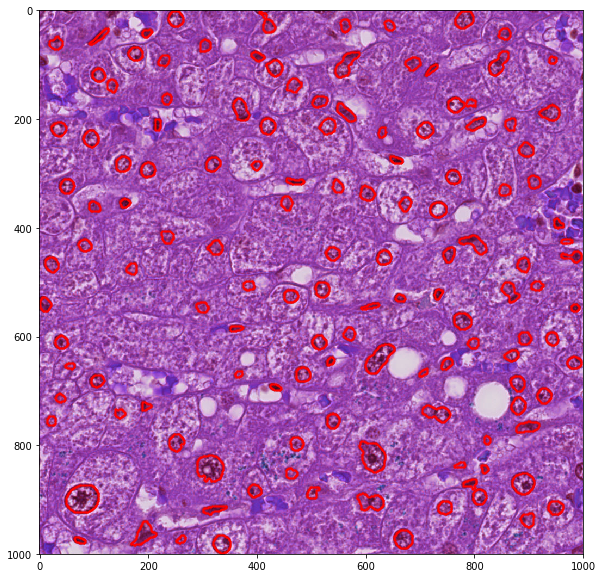

In [16]:
def get_tiff_from_json(json_name):
    names = json_name.split('.')
    return names[0]+'.tiff'

img = imread(ORIGINAL_PATH + get_tiff_from_json(json_files[0]))

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.scatter(x,y, c='red', s=0.5)

### check convert_coordinate_to_mask  (Optional)

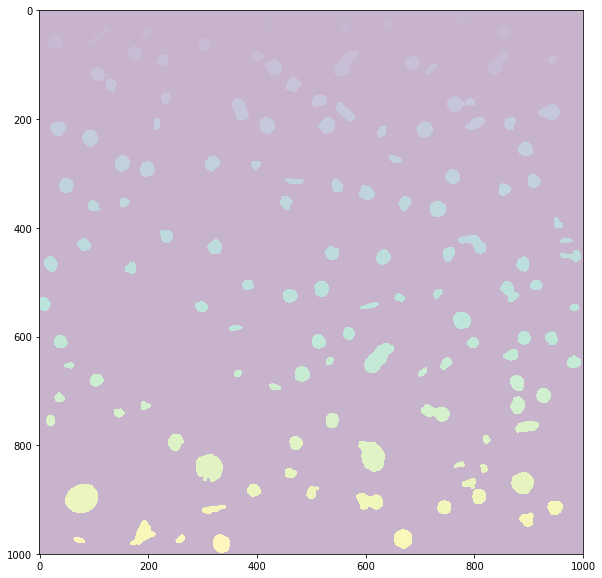

In [18]:
mask_total = convert_coordinate_to_mask(read_data, img.shape[:2], type="different")

plt.figure(figsize=(10,10))
# plt.imshow(img)
# plt.scatter(x,y, c='red', s=0.5)
plt.imshow(mask_total, alpha=0.3)
plt.show()

### check save file  (Optional)

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141],
      dtype=uint16)

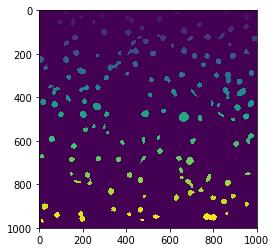

In [19]:
mask_files = next(os.walk(SAVE_PATH))[2]
mask = imread(SAVE_PATH + mask_files[2])
plt.imshow(mask)
np.unique(mask)

### change tiff to png

In [20]:
from shutil import copyfile

ORIGINAL_PATH 
SAVE_PATH = DATASET_PATH + 'png_image/'
for tiff_file in tiff_files:
    if not os.path.isdir(SAVE_PATH):
        os.mkdir(SAVE_PATH)
    img = imread(ORIGINAL_PATH + tiff_file)
    save_name = tiff_file.split('.')[0]
    scipy.misc.imsave(SAVE_PATH + save_name + '.png', img)
#     copyfile(ORIGINAL_PATH + tiff_file, SAVE_PATH + tiff_file)


/home/aiy/anaconda3/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2611: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  strip = decompress(strip)
/home/aiy/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `imsave` is deprecated!
`imsave` is deprecated in SciPy 1.0.0, and will be removed in 1.2.0.
Use ``imageio.imwrite`` instead.
  # Remove the CWD from sys.path while we load stuff.


### Crop CRLM dataset to 336x336 pixels

In [30]:
DATASET_PATH = '../dataset/John Dataset2/'
SAVED_PATH = DATASET_PATH + 'cropped_John_data/'

image_path = DATASET_PATH + 'png_image/'
mask_path = DATASET_PATH + 'mask2/'

CROP_SIZE = 336

In [31]:
image_file_names = next(os.walk(image_path))[2]
mask_file_names = next(os.walk(mask_path))[2]

In [32]:
import imageio

if not os.path.isdir(SAVED_PATH):
    os.mkdir(SAVED_PATH)
    os.mkdir(SAVED_PATH+'masks')
    os.mkdir(SAVED_PATH+'images')
    

for mask_file_name in mask_file_names:
    save_name = mask_file_name.split('.')[0]
    
    mask = imread(mask_path + mask_file_name)
    mask[mask>0] = 255
#     imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_1.png", mask[:CROP_SIZE, :CROP_SIZE])
#     imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_2.png", mask[-CROP_SIZE:, :CROP_SIZE])
#     imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_3.png", mask[:CROP_SIZE, -CROP_SIZE:])
#     imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_4.png", mask[-CROP_SIZE:, -CROP_SIZE:])
    
#     image = imread(image_path + mask_file_name)
#     imageio.imwrite(f"{SAVED_PATH}images/{save_name}_1.png", image[:CROP_SIZE, :CROP_SIZE])
#     imageio.imwrite(f"{SAVED_PATH}images/{save_name}_2.png", image[-CROP_SIZE:, :CROP_SIZE])
#     imageio.imwrite(f"{SAVED_PATH}images/{save_name}_3.png", image[:CROP_SIZE, -CROP_SIZE:])
#     imageio.imwrite(f"{SAVED_PATH}images/{save_name}_4.png", image[-CROP_SIZE:, -CROP_SIZE:])
    

    
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_1.png", mask[:CROP_SIZE, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_2.png", mask[-CROP_SIZE:, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_3.png", mask[:CROP_SIZE, -CROP_SIZE:])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_4.png", mask[-CROP_SIZE:, -CROP_SIZE:])
    
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_5.png", mask[CROP_SIZE:2*CROP_SIZE, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_6.png", mask[:CROP_SIZE, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_7.png", mask[CROP_SIZE:2*CROP_SIZE, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_8.png", mask[-CROP_SIZE:, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}masks/{save_name}_9.png", mask[CROP_SIZE:2*CROP_SIZE, -CROP_SIZE:])
    
    image = imread(image_path + mask_file_name)
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_1.png", image[:CROP_SIZE, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_2.png", image[-CROP_SIZE:, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_3.png", image[:CROP_SIZE, -CROP_SIZE:])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_4.png", image[-CROP_SIZE:, -CROP_SIZE:])
    
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_5.png", image[CROP_SIZE:2*CROP_SIZE, :CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_6.png", image[:CROP_SIZE, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_7.png", image[CROP_SIZE:2*CROP_SIZE, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_8.png", image[-CROP_SIZE:, CROP_SIZE:2*CROP_SIZE])
    imageio.imwrite(f"{SAVED_PATH}images/{save_name}_9.png", image[CROP_SIZE:2*CROP_SIZE, -CROP_SIZE:])